# Task 3 - Data Visualization using Matplotlib

### Task 3.a Streaming Data Visualization

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.0 pyspark-shell'

#import geohash 
#import ast
import sys
#import time
import json
import matplotlib.pyplot as plt

from kafka import KafkaConsumer
#from pyspark import SparkContext, SparkConf
#from pyspark.streaming import StreamingContext

<IPython.core.display.Javascript object>


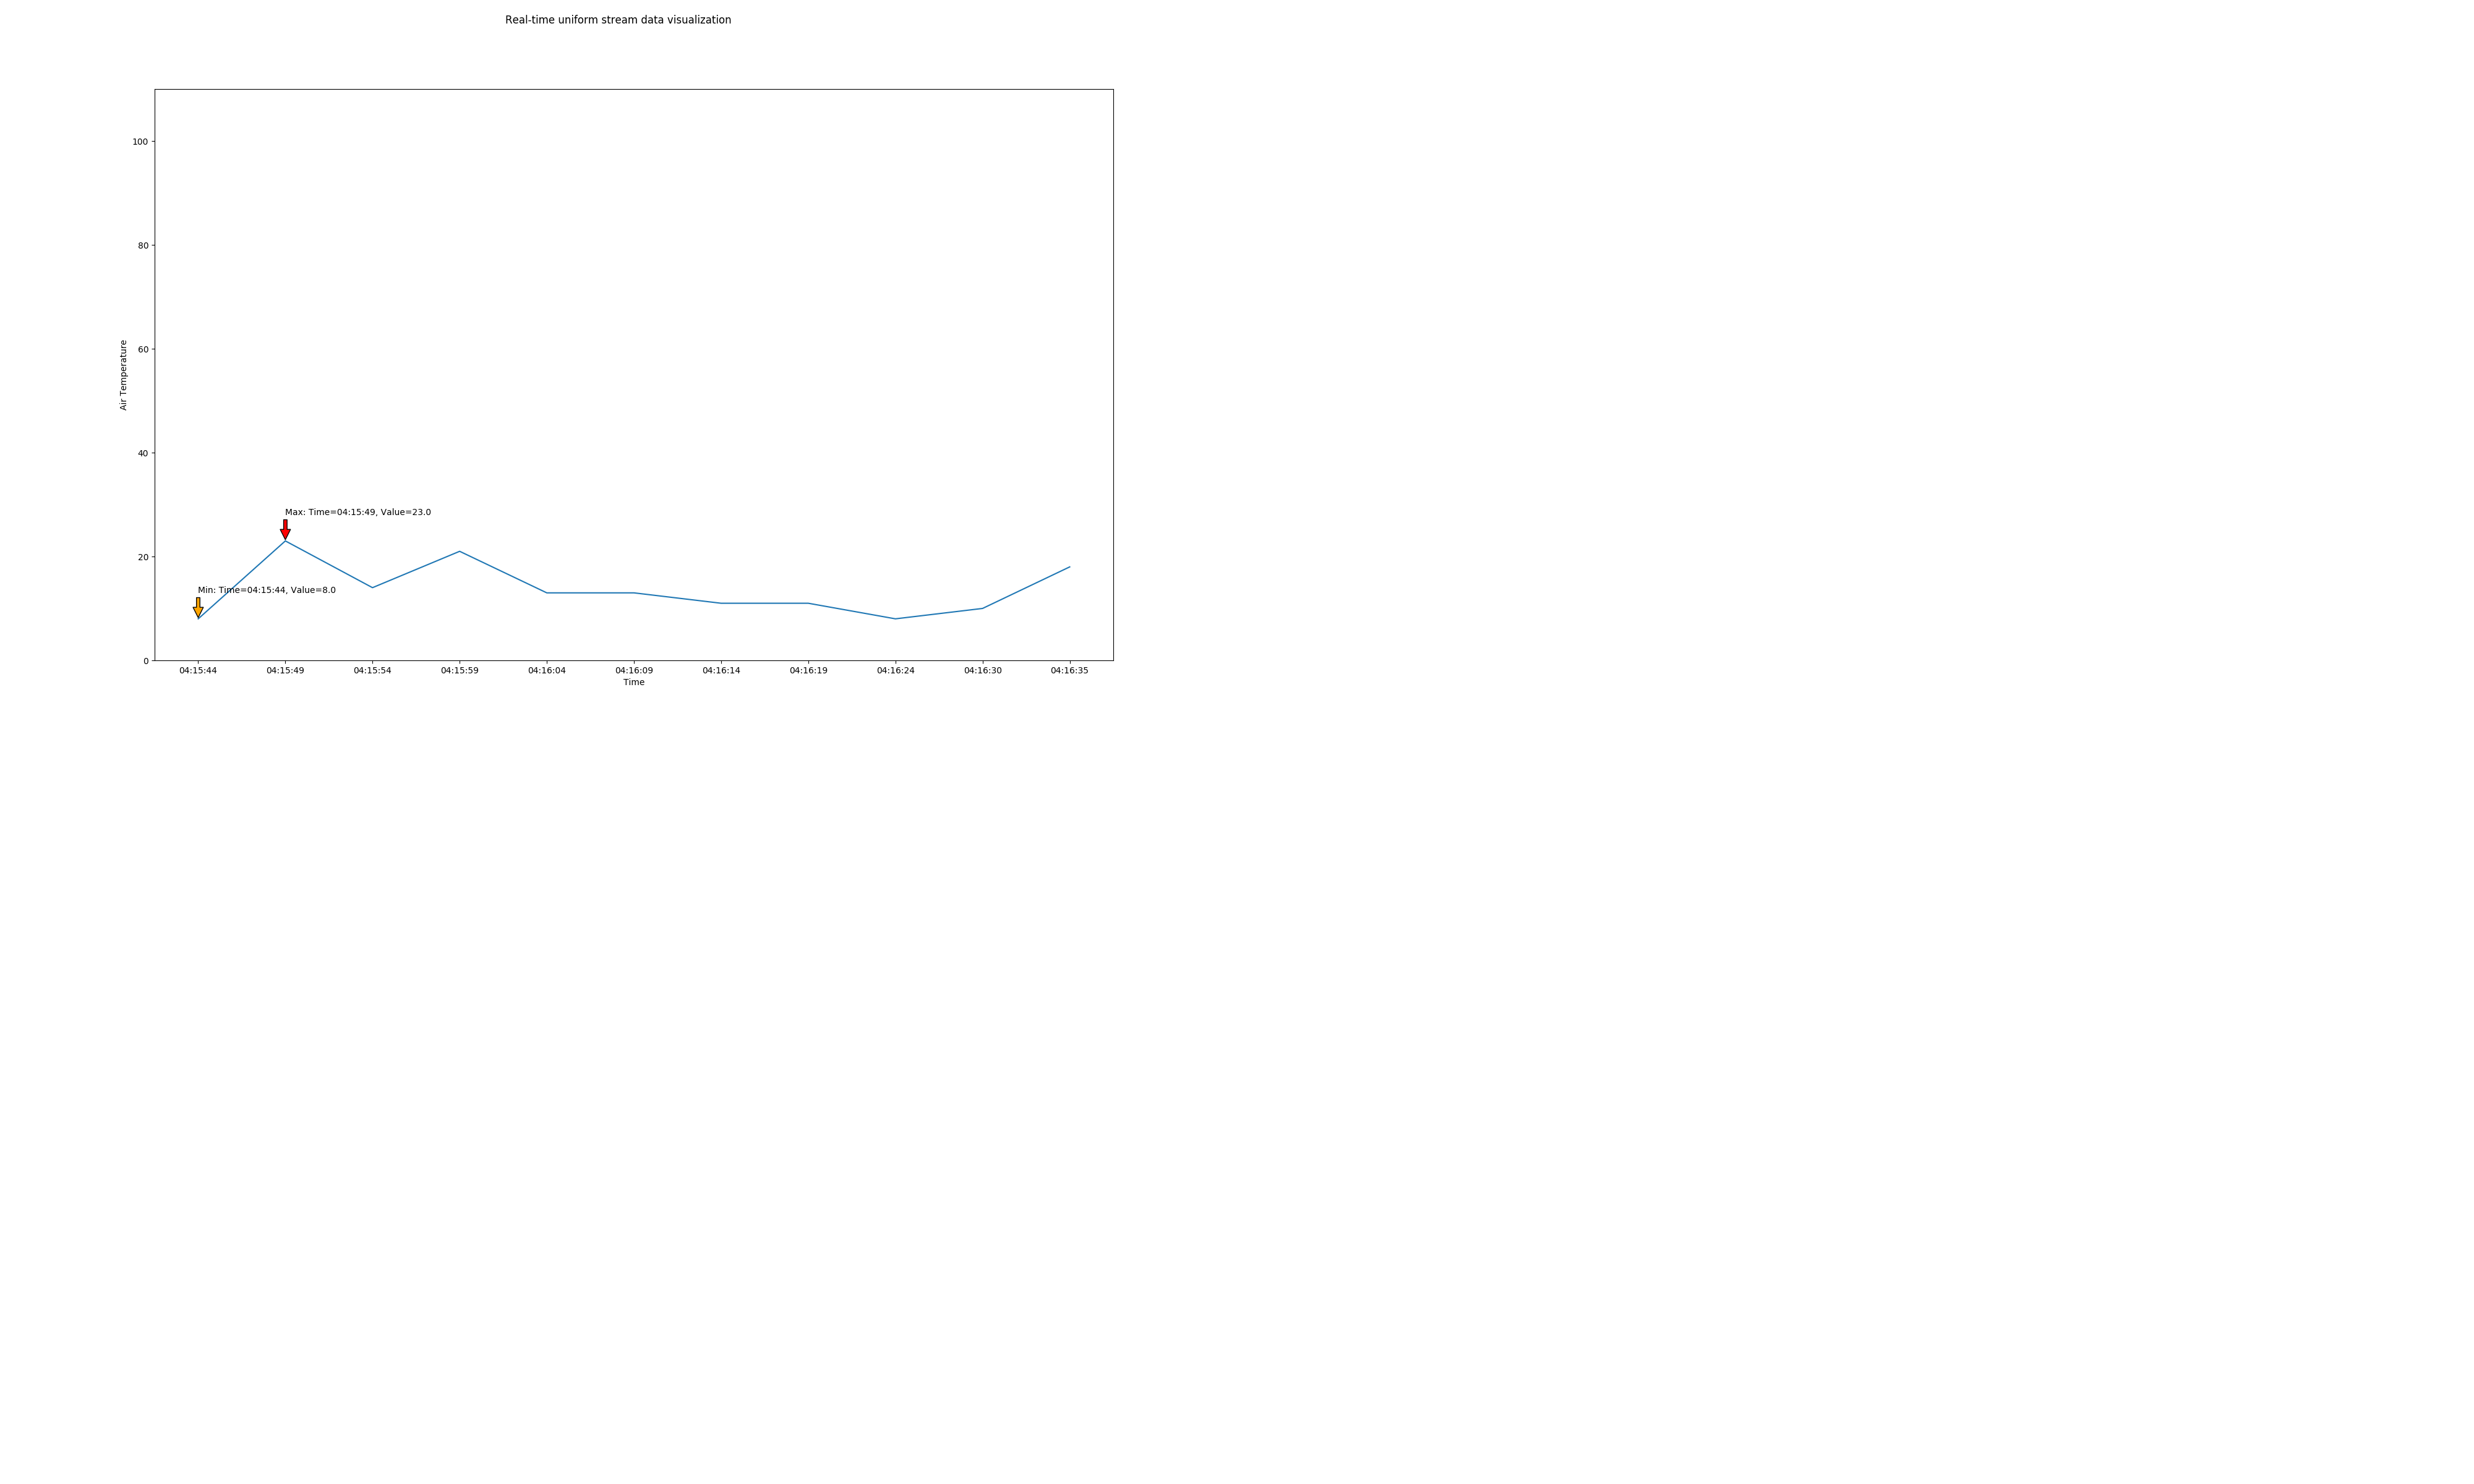

KeyboardInterrupt: 

In [2]:
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'StopFire'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   #auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['127.0.0.1:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer
def init_plots():
    try:
        width = 20
        height = 12
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.set_ylim(0,110) 
        ax.set_yticks([0,20,40,60,80,100])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = message.value.decode('utf-8')
            data_json = json.loads(data)
            #print(data_json)
            x.append(str(data_json['datetime']))
            y.append(float(data_json['data']['air_temperature_celcius']))
            #print(y)
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Air Temperature')
                ax.set_ylim(0,110) 
                ax.set_yticks([0,20,40,60,80,100])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

### Task 3.b.i Static Data Visualization

The collection created in TaskC (db.joined) barely match latitude and longitude to collect hotspot data. So we have decided to use hotspot data from Task B.

In [3]:
from pprint import pprint
from pymongo import MongoClient

In [4]:
client = MongoClient()
db = client.fit5148_assignment_db
hot = db.collection_hotspot

In [5]:

xaxis = []
yaxis = []
for i in db.collection_hotspot.aggregate([{"$group" : {"_id":"$date","count":{"$sum":1}}},{"$sort":{"count":-1}},{"$limit" : 10}]):
    xaxis.append(i["_id"])
    yaxis.append(i["count"])

In [6]:
xaxis,yaxis

(['13/04/2017',
  '18/04/2017',
  '4/05/2017',
  '6/04/2017',
  '10/05/2017',
  '15/05/2017',
  '4/04/2017',
  '3/04/2017',
  '12/04/2017',
  '15/04/2017'],
 [357, 325, 135, 118, 114, 102, 89, 72, 69, 69])

<IPython.core.display.Javascript object>


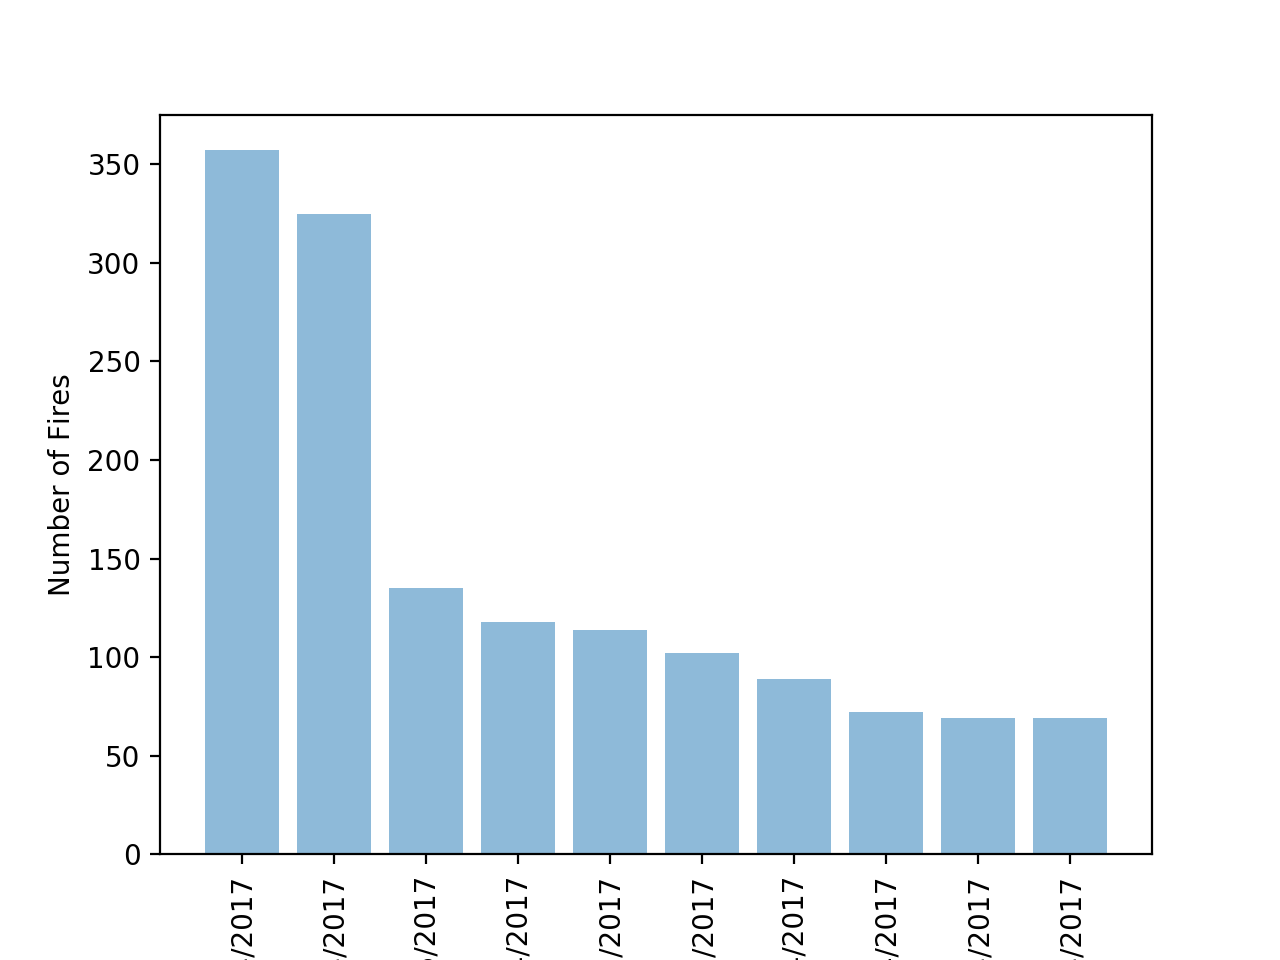

In [7]:
plt.figure()
plt.bar(xaxis, yaxis, align='center', alpha=0.5)
plt.xticks(rotation='vertical')
plt.ylabel('Number of Fires')
plt.xlabel('Date')

plt.show()


### Task 3.b.ii Static Data Visualization

In [16]:
import gmplot
import webbrowser
from pprint import pprint
from pymongo import MongoClient
import Geohash

# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 15) # latitude and longitude of melbourne city

client = MongoClient()

#embedded model from TaskB
db = client.fit5148_assignment_db
collection_embedded = db.collection_embedded

data = collection_embedded.aggregate([{"$unwind":"$hotspot"},{'$project':{'latitude':"$hotspot.location.latitude",'longitude':"$hotspot.location.longitude","surface_temperature":"$hotspot.surface_temperature_celcius","air_temperature":"$air_temperature_celcius","confidence":"$hotspot.confidence","relative_humidity":"$relative_humidity"}}])

newdata = []
for i in data:
    i['geo'] = Geohash.encode(i['latitude'][0], i['longitude'][0], precision=5)
    newdata.append(i)

for i in newdata:
    gmap.marker(float(i['latitude'][0]), float(i['longitude'][0]), 'red', title = str('surface_temperature:'+str(i['surface_temperature'])+', air_temperature:'+str(i['air_temperature'])+', relative_humidity:'+str(i['relative_humidity'])+', confidence:'+str(i['confidence'])))
    
# Open web browser and draw the map
gmap.draw("firemap.html")
webbrowser.open_new("firemap.html")

True